<a href="https://colab.research.google.com/github/ol-s-cloud/heavy-oil-rheology-ml/blob/main/Heavy_Oil_Rheology_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Modeling for Apparent Viscosity


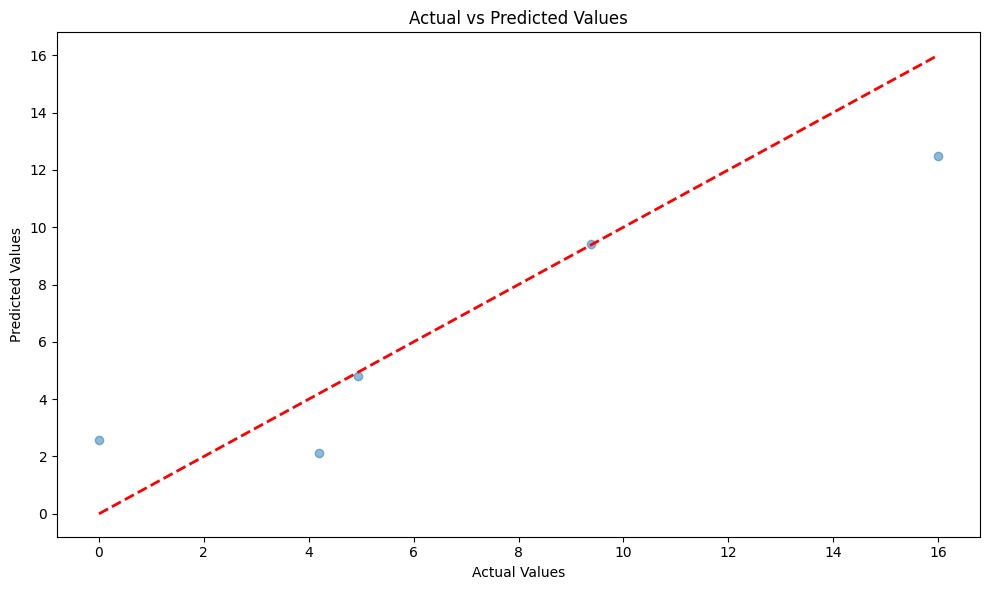

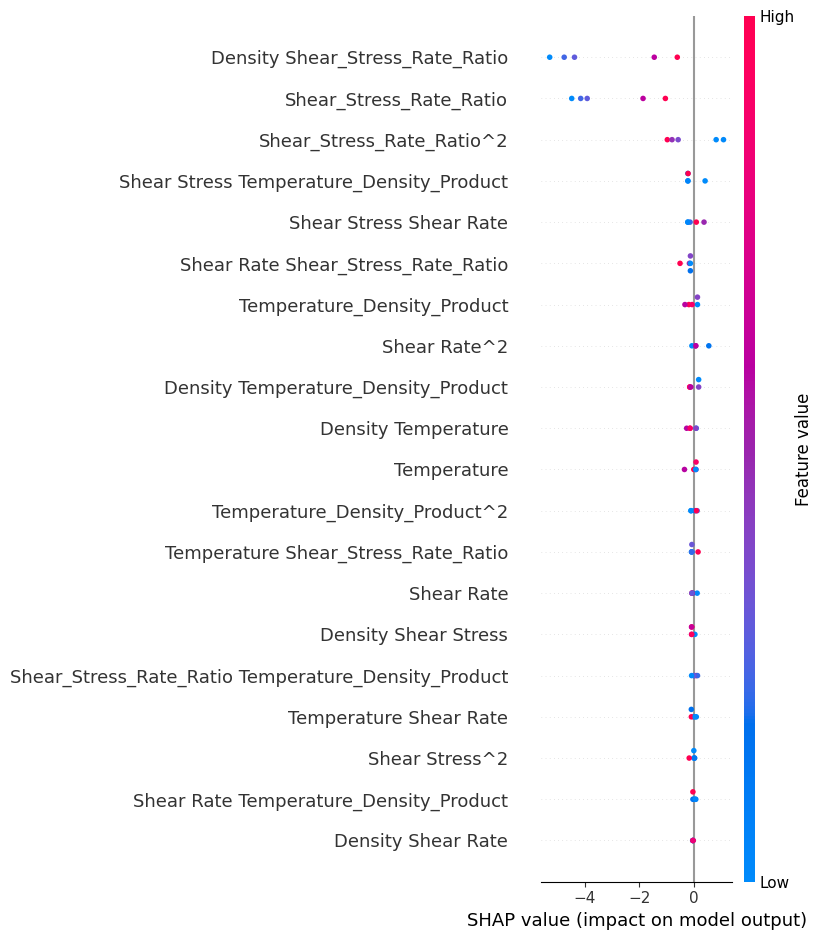

RMSE: 2.1546
R2 Score: 0.8428
MAE: 1.6650

Modeling for Plastic Viscosity


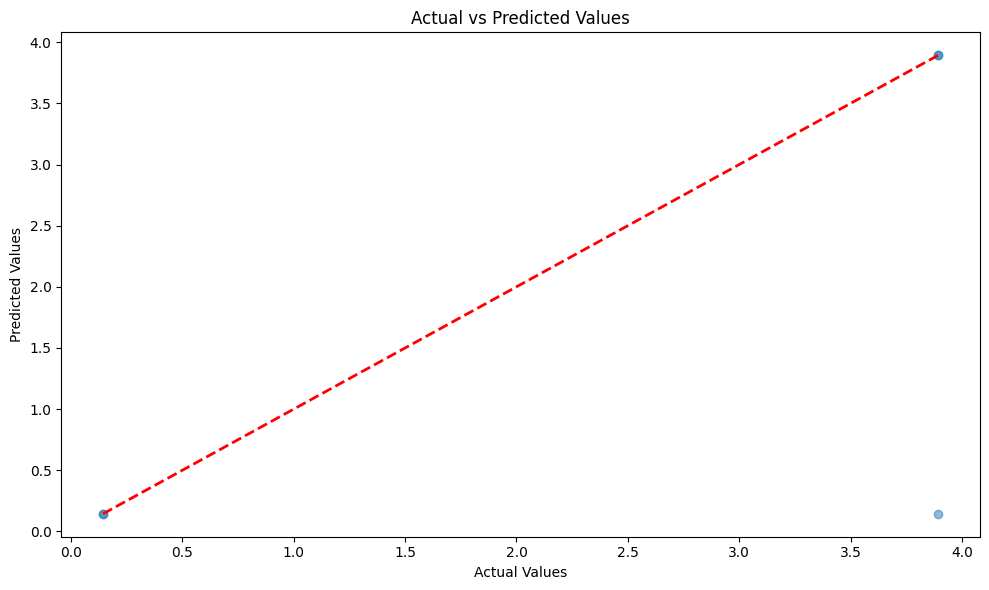

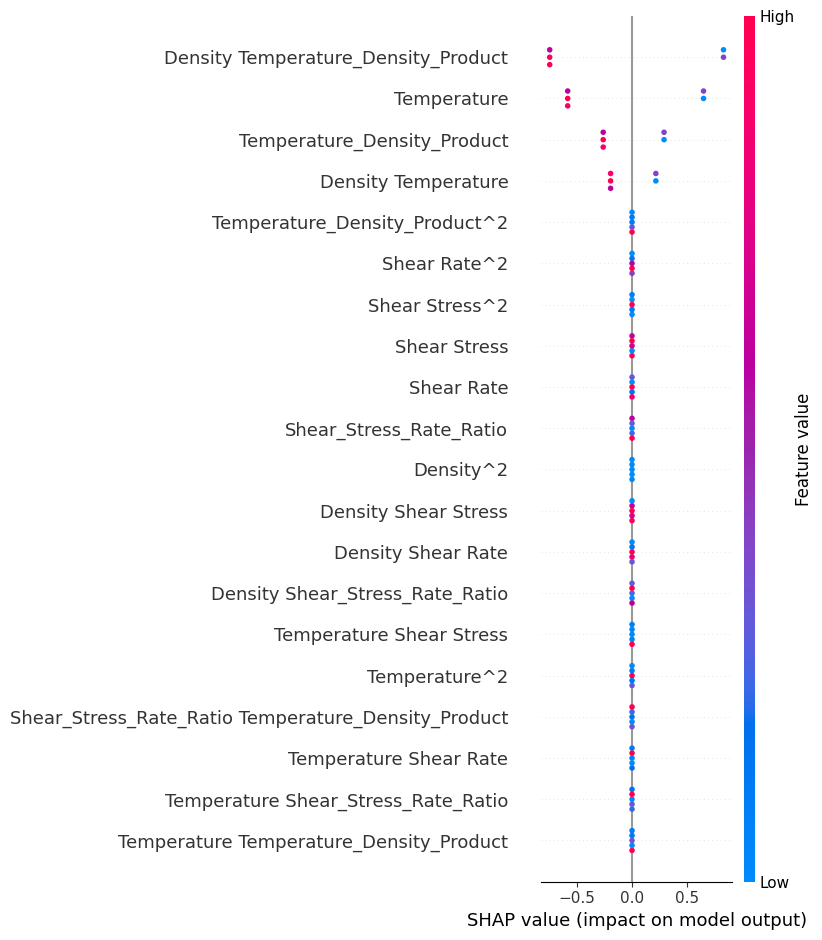

RMSE: 1.6773
R2 Score: 0.1667
MAE: 0.7502

Modeling for Yield Point


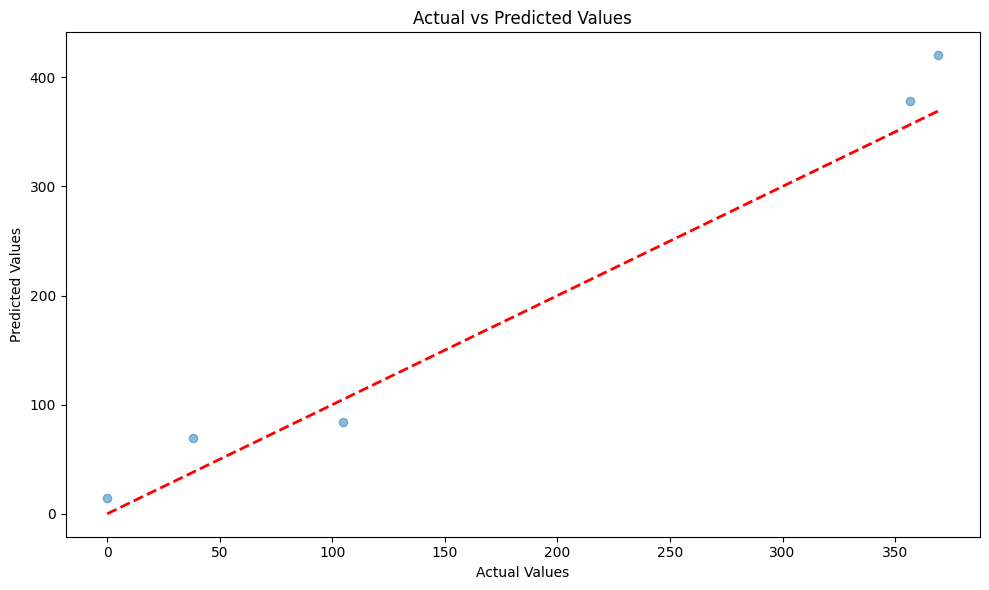

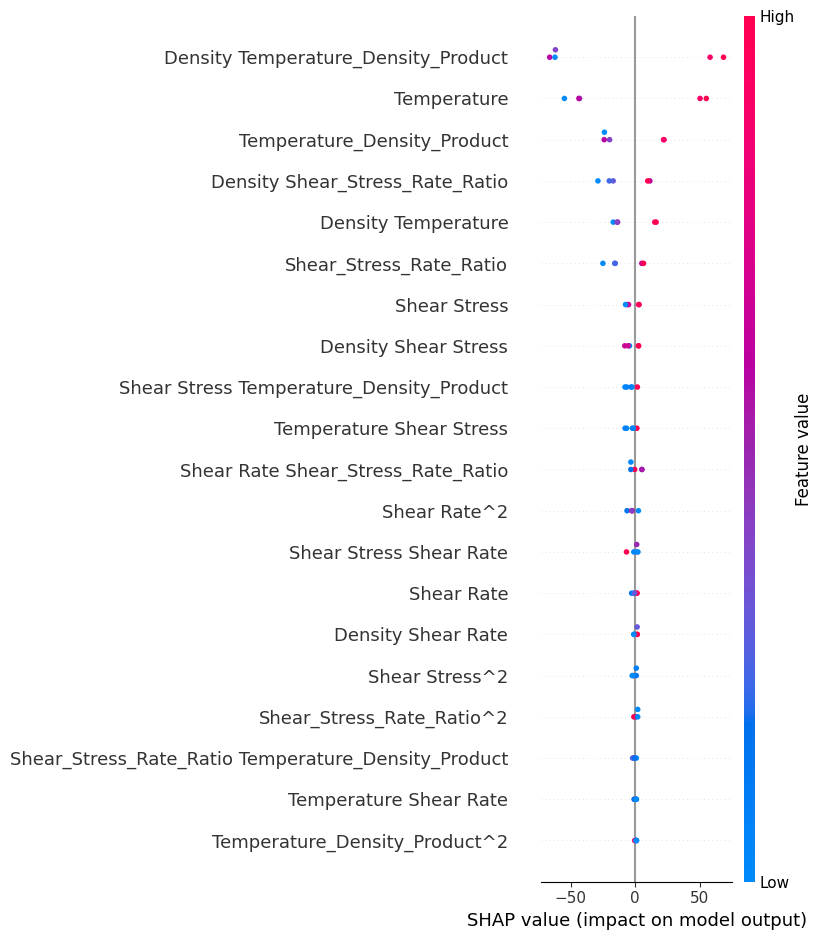

RMSE: 30.5390
R2 Score: 0.9627
MAE: 27.7179


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import shap

# Data preparation with added features and dataset labels
def prepare_data():
    """
    Prepare and combine data from three tables: Table 4.1, Table 4.2.1, and Table 4.2.2.
    Adds new features for model training and analysis.

    Returns:
        pd.DataFrame: Combined and preprocessed dataset.
    """
    # Table 4.1: Kinematic and Dynamic Viscosity under Standard and Thermal Conditions
    data_41 = {
        "Density": [0.95, 0.95],
        "Temperature": [60, 977],
        "Dynamic Viscosity": [7.7672, 2.014],
        "Kinematic Viscosity": [8.176, 2.120],
    }

    # Table 4.2.1: Shear Rate Rheology for Natural Bitumen
    data_421 = {
        "Shear Stress": [0, 225, 325, 350, 360, 455, 375, 433.5, 494, 510, 550, 525],
        "Shear Rate": [0, 40, 45, 50, 60, 70, 80, 90, 100, 110, 120, 125],
        "Apparent Viscosity": [0, 5.625, 7.222, 7.0, 6.0, 6.5, 4.6875, 4.8167, 4.94, 4.6364, 4.5833, 4.2],
        "Plastic Viscosity": [3.894] * 12,
        "Yield Point": [0, 69.24, 149.77, 155.3, 126.36, 182.42, 63.48, 83.04, 104.6, 81.66, 82.72, 38.25],
    }

    # Table 4.2.2: Apparent Viscosity for Natural Bitumen at 977°F
    data_422 = {
        "Shear Stress": [0, 225, 325, 350, 360, 455, 375, 433.5, 494, 510, 550, 525],
        "Shear Rate": [0, 3, 9, 15, 22, 32, 40, 47, 55, 61, 67, 72],
        "Apparent Viscosity": [0, 75.0, 36, 32, 16, 14, 9.375, 9.2234, 8.98182, 8.36066, 8.20896, 7.39437],
        "Plastic Viscosity": [0.1433] * 12,
        "Yield Point": [0, 224.57, 323.71, 347.85, 356.85, 450.41, 369.27, 426.76, 486.12, 501.26, 540.40, 514.68],
    }

    # Convert tables into DataFrames
    df_41 = pd.DataFrame(data_41)
    df_421 = pd.DataFrame(data_421)
    df_422 = pd.DataFrame(data_422)

    # Add dataset labels for identification
    df_421["Dataset"] = "Table 4.2.1"
    df_422["Dataset"] = "Table 4.2.2"

    # Combine all data into a single DataFrame
    data_combined = pd.concat([df_421, df_422], ignore_index=True)

    # Add density and temperature columns from Table 4.1
    data_combined["Density"] = 0.95
    data_combined["Temperature"] = np.linspace(60, 977, len(data_combined))

    # Feature engineering: create additional features for better modeling
    data_combined["Shear_Stress_Rate_Ratio"] = data_combined["Shear Stress"] / (data_combined["Shear Rate"] + 1e-6)
    data_combined["Temperature_Density_Product"] = data_combined["Temperature"] * data_combined["Density"]

    return data_combined

# Function to create a machine learning pipeline
def create_model_pipeline():
    """
    Create a pipeline with data preprocessing and a Gradient Boosting Regressor.

    Returns:
        sklearn.pipeline.Pipeline: Configured pipeline object.
    """
    gb_regressor = GradientBoostingRegressor(
        n_estimators=100,  # Number of trees
        learning_rate=0.1,  # Step size for optimization
        max_depth=3,  # Maximum depth of each tree
        random_state=42  # Random seed for reproducibility
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize features by removing mean and scaling to unit variance
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Add polynomial interaction terms
        ('regressor', gb_regressor)  # Gradient Boosting Regressor as the model
    ])

    return pipeline

# Function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test, feature_names):
    """
    Train the model, evaluate performance, and visualize results.

    Args:
        model (Pipeline): The machine learning pipeline.
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target.
        y_test (pd.Series): Testing target.
        feature_names (list): List of original feature names.

    Returns:
        dict: Evaluation metrics and trained model.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Visualization: Actual vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.show()

    # Feature importance analysis using SHAP
    explainer = shap.TreeExplainer(model.named_steps['regressor'])
    shap_values = explainer.shap_values(model.named_steps['poly'].transform(
        model.named_steps['scaler'].transform(X_test)))

    # Get feature names after polynomial transformation
    poly_features = model.named_steps['poly'].get_feature_names_out(feature_names)

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, model.named_steps['poly'].transform(
        model.named_steps['scaler'].transform(X_test)),
        feature_names=poly_features)

    return {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'model': model
    }

# Main execution block
if __name__ == "__main__":
    # Prepare the dataset
    data_combined = prepare_data()

    # Define features and target variables
    features = ["Density", "Temperature", "Shear Stress", "Shear Rate",
                "Shear_Stress_Rate_Ratio", "Temperature_Density_Product"]
    targets = ["Apparent Viscosity", "Plastic Viscosity", "Yield Point"]

    # Dictionary to store results for each target variable
    results = {}

    # Loop through each target variable
    for target in targets:
        print(f"\nModeling for {target}")

        # Split data into training and testing sets
        X = data_combined[features]
        y = data_combined[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and evaluate the model pipeline
        model = create_model_pipeline()
        results[target] = evaluate_model(model, X_train, X_test, y_train, y_test, features)

        # Print evaluation metrics
        print(f"RMSE: {results[target]['rmse']:.4f}")
        print(f"R2 Score: {results[target]['r2']:.4f}")
        print(f"MAE: {results[target]['mae']:.4f}")
